### Import libraries

In [1]:
# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
# Pandas
import pandas as pd

# Numpy
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [3]:
# Neural network
from sklearn.neural_network import MLPClassifier

# Pipeline
from sklearn.pipeline import Pipeline

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

# Metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import silhouette_samples

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection # Randomized Projections
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture # Expectation Maximization

### Load Data

In [4]:
magic_df = pd.read_csv('./data/magic04.data', header=None, error_bad_lines=False)

# Full Data
X = magic_df.iloc[:, :-1].values
y = magic_df.iloc[:, -1].values

# Convert labels from ['h', 'g'] to [1, 0]
le = LabelEncoder()
y = le.fit_transform(y)

# Split data into train and test
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=42)

### Plotting Functions

In [5]:
def plot_elbow_distortions(max_clusters, X, title=None, save_as=None):
    distortions = []
    for i in range(1, max_clusters+1):
        km = KMeans(n_clusters=i, 
                    init='k-means++', 
                    n_init=10, 
                    max_iter=300, 
                    random_state=42)
        km.fit(X)
        distortions.append(km.inertia_)
    plt.plot(range(1, max_clusters+1), distortions, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [6]:
def plot_elbow_bic(max_components, X, title=None, save_as=None):
    bic = []
    for i in range(1, max_components+1):
        gmm = GaussianMixture(n_components=i, 
                              covariance_type='full',
                              reg_covar=1e-06, 
                              max_iter=100, 
                              n_init=1, 
                              init_params='kmeans',
                              random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))
    plt.plot(range(1, max_components+1), bic, marker='s')
    plt.xlabel('Number of Components')
    plt.ylabel('Bayesian Information Criterion')
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [7]:
def plot_silhouette(km, X, title=None, save_as=None):
    y_km = km.predict(X)
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                 edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="orange", linestyle="--") 

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette Coefficient')
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [8]:
def plot_kmeans(km, X, xlim=None, ylim=None, title=None, save_as=None):
    y_km = km.predict(X)
    colors = ('lightgreen', 'purple', 'blue', 'orange', 'cyan')
    markers = ('s', 'o', 'v', 'p', 'd')
    for i in range(0, km.n_clusters):
        plt.scatter(X[y_km == i, 0],
                    X[y_km == i, 1],
                    s=50, c=colors[i],
                    marker=markers[i], edgecolor='black',
                    label='cluster '+str(i+1))
    plt.scatter(km.cluster_centers_[:, 0],
                km.cluster_centers_[:, 1],
                s=250, marker='*',
                c='red', edgecolor='black',
                label='centroids')
    
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [9]:
def plot_gmm(gmm, X, index=1, xlim=None, ylim=None, title=None, save_as=None):
    import itertools
    from scipy import linalg
    import matplotlib as mpl
    
    splot = plt.subplot(1, 1, 1)
    y_gmm = gmm.predict(X)
    color_iter = itertools.cycle(['lightgreen', 'purple', 'blue', 'orange', 'cyan'])
    marker_iter = itertools.cycle(['s', 'o', 'v', 'p', 'd'])
    means = gmm.means_
    covariances = gmm.covariances_
    for i, (mean, covar, color, marker) in enumerate(zip(
            means, covariances, color_iter, marker_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(y_gmm == i):
            continue
        plt.scatter(X[y_gmm == i, 0], X[y_gmm == i, 1], 
                    color=color, marker=marker, edgecolor='black')

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.grid()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

## Clustering after Dimensionality Reduction

### Principal Component Analysis

#### Non-kernel PCA

In [10]:
pca = PCA(n_components=2, copy=True, 
          whiten=False, svd_solver='auto', 
          tol=0.0, iterated_power='auto', 
          random_state=42)

In [11]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [12]:
X_proj_pca = pca.inverse_transform(X_train_pca)

# Calculate reconstruction error
mse_pca = ((X_train - X_proj_pca)**2).mean()
print(mse_pca)

451.6476272596436


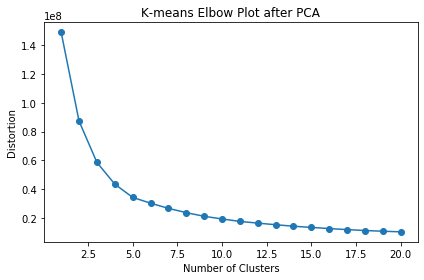

In [13]:
# Elbow around k=4
plot_elbow_distortions(max_clusters=20, X=X_train_pca, title='K-means Elbow Plot after PCA', 
                       save_as='MAGIC/2 Components/kmeans_elbow_plot_PCA')

In [14]:
kmeans = KMeans(n_clusters=4, init='k-means++', 
                n_init=10, max_iter=300, verbose=0, 
                random_state=42, n_jobs=-1,
                algorithm='auto')

In [15]:
%%time
kmeans.fit(X_train_pca)

Wall time: 1.86 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

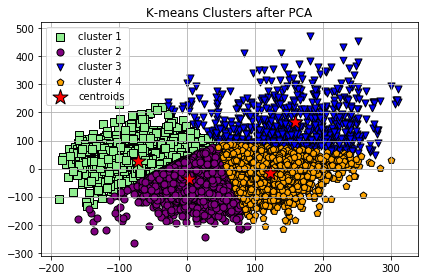

In [16]:
plot_kmeans(km=kmeans, X=X_train_pca, title='K-means Clusters after PCA', save_as='MAGIC/2 Components/kmeans_clusters_PCA')

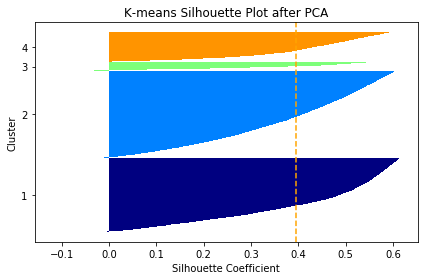

In [17]:
plot_silhouette(km=kmeans, X=X_train_pca, title='K-means Silhouette Plot after PCA', 
                save_as='MAGIC/2 Components/silhouette_plot_PCA')

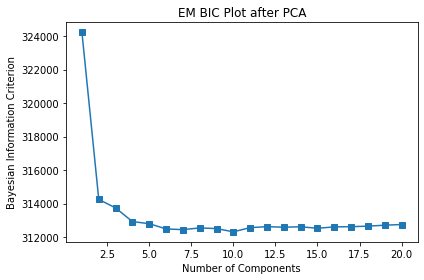

In [18]:
plot_elbow_bic(max_components=20, X=X_train_pca, title='EM BIC Plot after PCA', 
               save_as='MAGIC/2 Components/EM_BIC_plot_PCA')

In [19]:
gaussian_mix = GaussianMixture(n_components=4, covariance_type='full', 
                               max_iter=100, init_params='kmeans',
                               random_state=42, verbose=0, verbose_interval=10)

In [20]:
%%time
gaussian_mix.fit(X_train_pca)

Wall time: 92.8 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

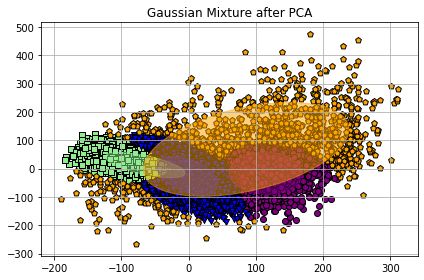

In [21]:
plot_gmm(gmm=gaussian_mix, X=X_train_pca, title='Gaussian Mixture after PCA', 
         save_as='MAGIC/2 Components/gmm_clusters_PCA')

#### Kernel PCA

In [22]:
kpca = KernelPCA(n_components=2, kernel='rbf', 
                 gamma=None, degree=3, 
                 coef0=1, kernel_params=None, 
                 alpha=1.0, fit_inverse_transform=True, 
                 random_state=42, 
                 n_jobs=-1)

In [23]:
X_train_kpca = kpca.fit_transform(X_train)
X_test_kpca = kpca.transform(X_test)

In [24]:
X_proj_kpca = kpca.inverse_transform(X_train_kpca)

# Calculate reconstruction error
mse_kpca = ((X_train - X_proj_kpca)**2).mean()
print(mse_kpca)

1496.3016172779091


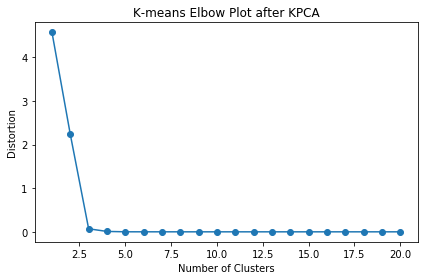

In [25]:
# Elbow around k=3
plot_elbow_distortions(max_clusters=20, X=X_train_kpca, title='K-means Elbow Plot after KPCA', 
                       save_as='MAGIC/2 Components/kmeans_elbow_plot_KPCA')

In [26]:
kmeans = KMeans(n_clusters=3, init='k-means++', 
                n_init=10, max_iter=300, verbose=0, 
                random_state=42, n_jobs=-1,
                algorithm='auto')

In [27]:
%%time
kmeans.fit(X_train_kpca)

Wall time: 1.71 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

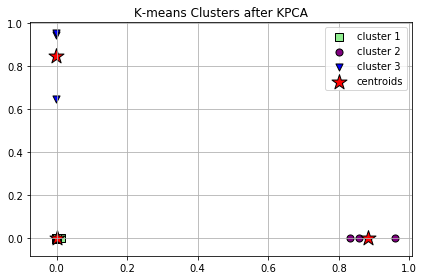

In [28]:
plot_kmeans(km=kmeans, X=X_train_kpca, title='K-means Clusters after KPCA', 
            save_as='MAGIC/2 Components/kmeans_clusters_KPCA')

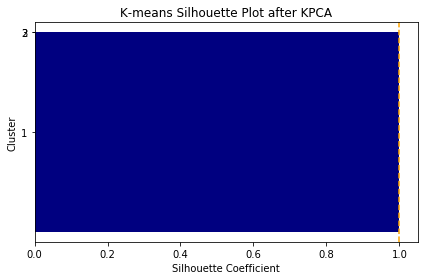

In [29]:
plot_silhouette(km=kmeans, X=X_train_kpca, title='K-means Silhouette Plot after KPCA', 
                save_as='MAGIC/2 Components/silhouette_plot_KPCA')

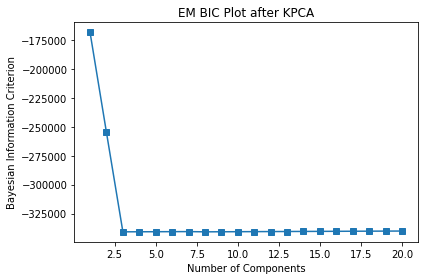

In [30]:
plot_elbow_bic(max_components=20, X=X_train_kpca, title='EM BIC Plot after KPCA', 
               save_as='MAGIC/2 Components/EM_BIC_plot_KPCA')

In [31]:
gaussian_mix = GaussianMixture(n_components=3, covariance_type='full', 
                               max_iter=100, init_params='kmeans',
                               random_state=42, verbose=0, verbose_interval=10)

In [32]:
%%time
gaussian_mix.fit(X_train_kpca)

Wall time: 21 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

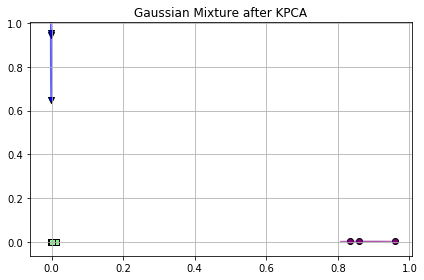

In [33]:
plot_gmm(gmm=gaussian_mix, X=X_train_kpca, title='Gaussian Mixture after KPCA', 
         save_as='MAGIC/2 Components/gmm_clusters_KPCA')

### Independent Component Analysis

In [34]:
ica = FastICA(n_components=2, algorithm='parallel', 
              whiten=True, fun='logcosh', fun_args=None, 
              max_iter=200, tol=0.0001, w_init=None, 
              random_state=42)

In [35]:
X_train_ica = ica.fit_transform(X_train)
X_test_ica = ica.transform(X_test)

In [36]:
from scipy.stats import kurtosis

print(kurtosis(ica.components_[0], axis=0, fisher=True, bias=True))
print(kurtosis(ica.components_[1], axis=0, fisher=True, bias=True))

3.1121420074158106
0.5213559373657684


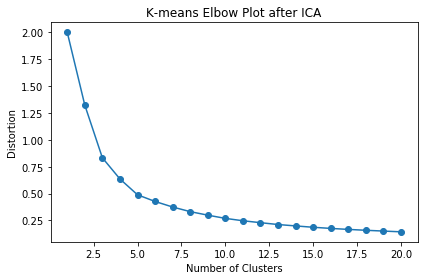

In [37]:
# Elbow around k=5
plot_elbow_distortions(max_clusters=20, X=X_train_ica, title='K-means Elbow Plot after ICA', 
                       save_as='MAGIC/2 Components/kmeans_elbow_plot_ICA')

In [38]:
kmeans = KMeans(n_clusters=5, init='k-means++', 
                n_init=10, max_iter=300, verbose=0, 
                random_state=42, n_jobs=-1,
                algorithm='auto')

In [39]:
%%time
kmeans.fit(X_train_ica)

Wall time: 1.84 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

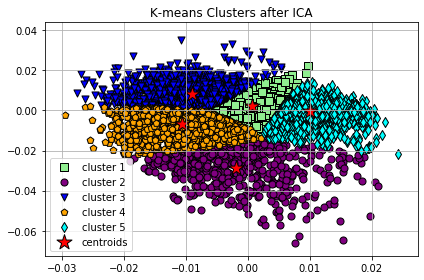

In [40]:
plot_kmeans(km=kmeans, X=X_train_ica, title='K-means Clusters after ICA', 
            save_as='MAGIC/2 Components/kmeans_clusters_ICA')

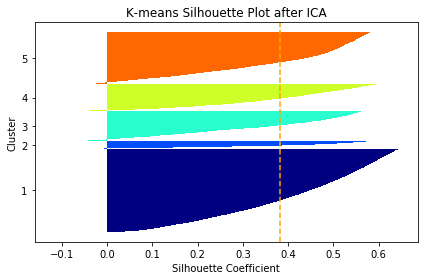

In [41]:
plot_silhouette(km=kmeans, X=X_train_ica, title='K-means Silhouette Plot after ICA', 
                save_as='MAGIC/2 Components/silhouette_plot_ICA')

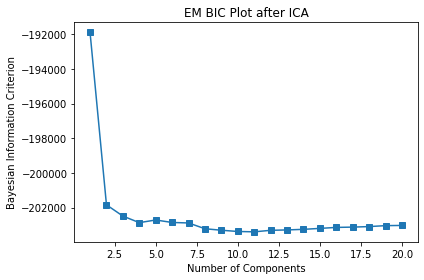

In [42]:
plot_elbow_bic(max_components=20, X=X_train_ica, title='EM BIC Plot after ICA', 
               save_as='MAGIC/2 Components/EM_BIC_plot_ICA')

In [43]:
gaussian_mix = GaussianMixture(n_components=4, covariance_type='full', 
                               max_iter=100, init_params='kmeans',
                               random_state=42, verbose=0, verbose_interval=10)

In [44]:
%%time
gaussian_mix.fit(X_train_ica)

Wall time: 71.8 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

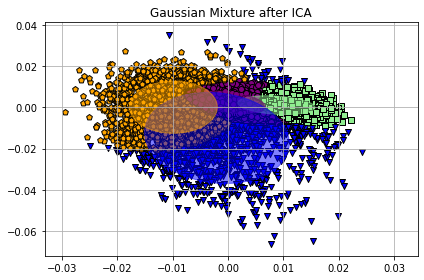

In [45]:
plot_gmm(gmm=gaussian_mix, X=X_train_ica, title='Gaussian Mixture after ICA', 
         save_as='MAGIC/2 Components/gmm_clusters_ICA')

### Random Projection (Gaussian)

In [46]:
grp = GaussianRandomProjection(n_components=2, 
                               eps=0.1, 
                               random_state=42)

In [47]:
X_train_grp = grp.fit_transform(X_train)
X_test_grp = grp.transform(X_test)

In [48]:
from scipy.linalg import pinv

w = grp.components_
p = pinv(w)
X_proj_grp = ((p@w)@(X_train.T)).T

# Calculate reconstruction error
mse_grp = ((X_train - X_proj_grp)**2).mean()
print(mse_grp)

4417.911791037496


In [70]:
mse_list = []
for i in range(1, 21):
    grp = GaussianRandomProjection(n_components=2, 
                                   eps=0.1, 
                                   random_state=i)
    X_train_grp = grp.fit_transform(X_train)
    X_test_grp = grp.transform(X_test)

    w = grp.components_
    p = pinv(w)
    X_proj_grp = ((p@w)@(X_train.T)).T
    # Calculate reconstruction error
    mse_grp = ((X_train - X_proj_grp)**2).mean()
    mse_list.append(mse_grp)

mse_list = np.array(mse_list)
print("Worst MSE: %0.3f" % (mse_list.max()))
print("Best MSE: %0.3f" % (mse_list.min()))
print("Average MSE: %0.3f (+/- %0.2f)" % (mse_list.mean(), mse_list.std()))

Worst MSE: 5494.656
Best MSE: 3014.142
Average MSE: 4635.897 (+/- 753.25)


In [49]:
from scipy.linalg import pinv

w = grp.components_
p = pinv(w)
X_proj_grp = ((p@w)@(X_train.T)).T

# Calculate reconstruction error
mse_grp = ((X_train - X_proj_grp)**2).mean()
print(mse_grp)

4417.911791037496


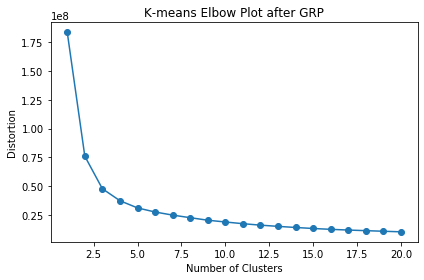

In [50]:
# Elbow around k=4
plot_elbow_distortions(max_clusters=20, X=X_train_grp, title='K-means Elbow Plot after GRP', 
                       save_as='MAGIC/2 Components/kmeans_elbow_plot_GRP')

In [51]:
kmeans = KMeans(n_clusters=4, init='k-means++', 
                n_init=10, max_iter=300, verbose=0, 
                random_state=42, n_jobs=-1,
                algorithm='auto')

In [52]:
%%time
kmeans.fit(X_train_grp)

Wall time: 1.83 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

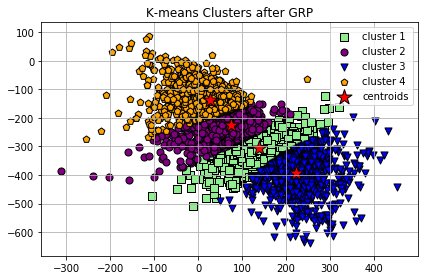

In [53]:
plot_kmeans(km=kmeans, X=X_train_grp, title='K-means Clusters after GRP', 
            save_as='MAGIC/2 Components/kmeans_clusters_GRP')

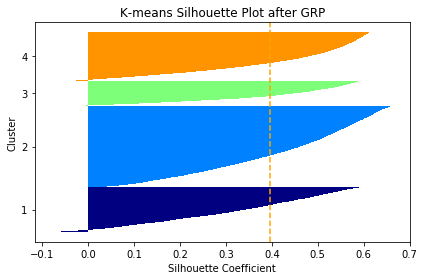

In [54]:
plot_silhouette(km=kmeans, X=X_train_grp, title='K-means Silhouette Plot after GRP', 
                save_as='MAGIC/2 Components/silhouette_plot_GRP')

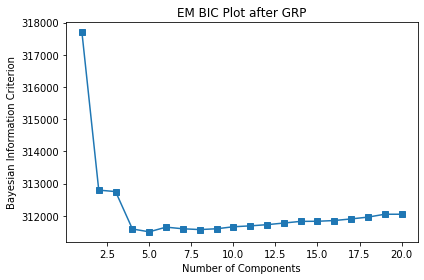

In [55]:
plot_elbow_bic(max_components=20, X=X_train_grp, title='EM BIC Plot after GRP', 
               save_as='MAGIC/2 Components/EM_BIC_plot_GRP')

In [56]:
gaussian_mix = GaussianMixture(n_components=4, covariance_type='full', 
                               max_iter=100, init_params='kmeans',
                               random_state=42, verbose=0, verbose_interval=10)

In [57]:
%%time
gaussian_mix.fit(X_train_grp)

Wall time: 184 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

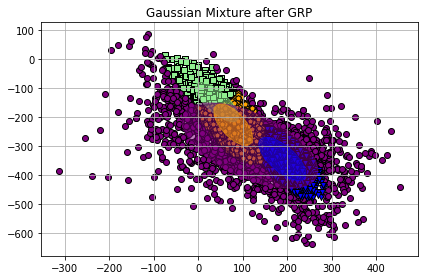

In [58]:
plot_gmm(gmm=gaussian_mix, X=X_train_grp, title='Gaussian Mixture after GRP', 
         save_as='MAGIC/2 Components/gmm_clusters_GRP')

### Linear Discriminant Analysis

In [59]:
lda = LinearDiscriminantAnalysis(n_components=1, 
                                 solver='svd', 
                                 store_covariance=False, 
                                 tol=0.0001)

In [60]:
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

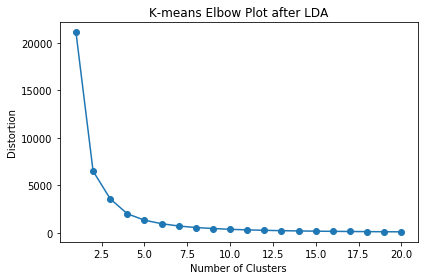

In [61]:
# Elbow around k=3
plot_elbow_distortions(max_clusters=20, X=X_train_lda, title='K-means Elbow Plot after LDA', 
                       save_as='MAGIC/2 Components/kmeans_elbow_plot_LDA')

In [62]:
kmeans = KMeans(n_clusters=4, init='k-means++', 
                n_init=10, max_iter=300, verbose=0, 
                random_state=42, n_jobs=-1,
                algorithm='auto')

In [63]:
%%time
kmeans.fit(X_train_lda)

Wall time: 1.76 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

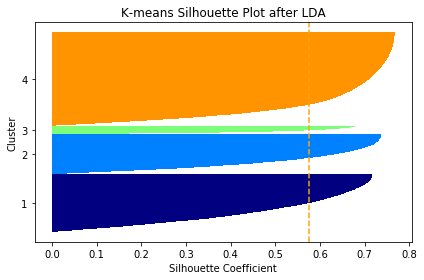

In [64]:
plot_silhouette(km=kmeans, X=X_train_lda, title='K-means Silhouette Plot after LDA', 
                save_as='MAGIC/2 Components/silhouette_plot_LDA')

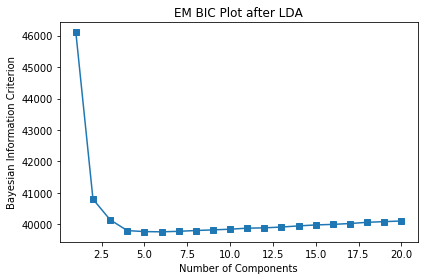

In [65]:
plot_elbow_bic(max_components=20, X=X_train_lda, title='EM BIC Plot after LDA', 
               save_as='MAGIC/2 Components/EM_BIC_plot_LDA')

In [66]:
gaussian_mix = GaussianMixture(n_components=4, covariance_type='full', 
                               max_iter=100, init_params='kmeans',
                               random_state=42, verbose=0, verbose_interval=10)

In [67]:
%%time
gaussian_mix.fit(X_train_lda)

Wall time: 32.9 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)